In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [18]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [19]:
np.random.seed(0)

## Generic Data

In [20]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


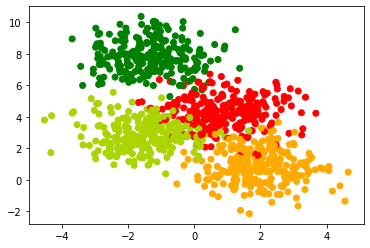

In [21]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [22]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

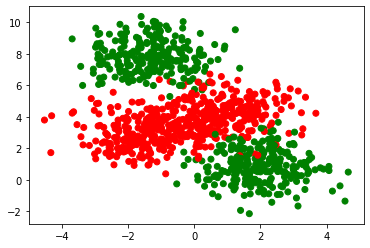

In [23]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [25]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [26]:
class FFNetwork:
  
  def __init__(self):
        
    self.params={}
    self.params["W1"]=np.random.randn(2,2)
    self.params["W2"]=np.random.randn(2,4)
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,4))
    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    return 1.0/(1.0 + np.exp(-X))
      
  def grad_activation(self, X):
    return X*(1-X) 

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = []
    for num_epoch in notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
    
    if display_loss:
      plt.plot(loss, '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [27]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

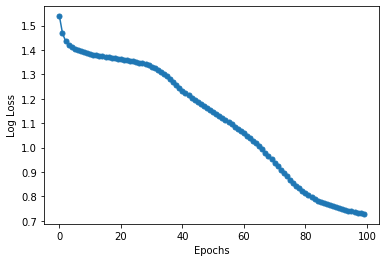

Training accuracy 0.7053
Validation accuracy 0.716
Wall time: 467 ms


In [28]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

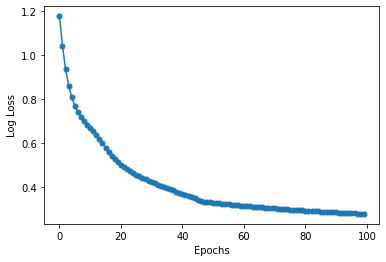

Training accuracy 0.896
Validation accuracy 0.9
Wall time: 389 ms


In [30]:

%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

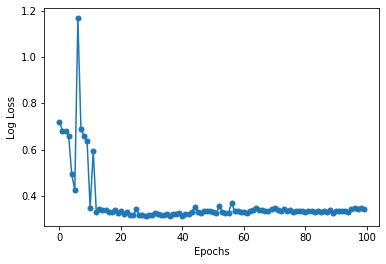

Training accuracy 0.8773
Validation accuracy 0.872
Wall time: 1.01 s


In [32]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

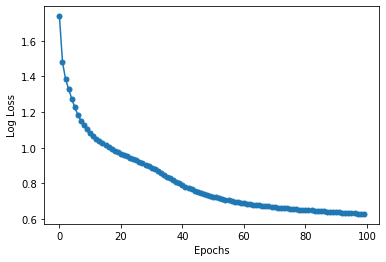

Training accuracy 0.7133
Validation accuracy 0.724
Wall time: 371 ms


In [34]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

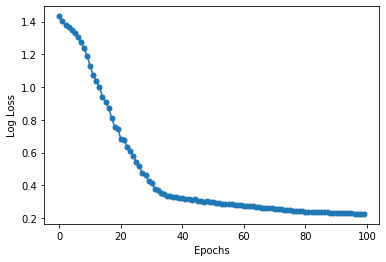

Training accuracy 0.908
Validation accuracy 0.94
Wall time: 378 ms


In [36]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

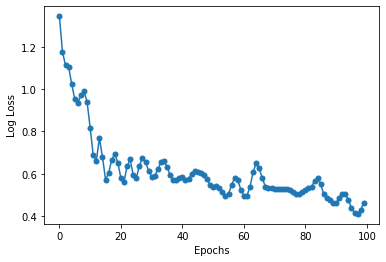

Training accuracy 0.84
Validation accuracy 0.828
Wall time: 384 ms


In [40]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

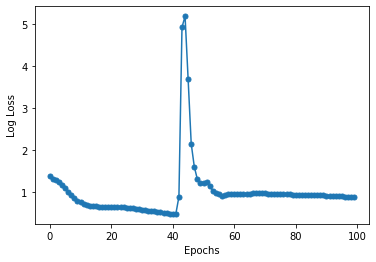

Training accuracy 0.62
Validation accuracy 0.636
Wall time: 382 ms


In [47]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

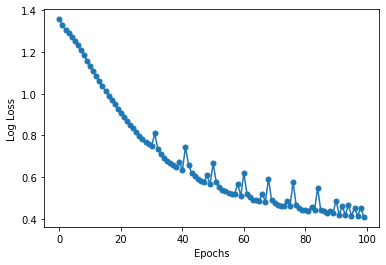

Training accuracy 0.884
Validation accuracy 0.892
Wall time: 371 ms


In [55]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

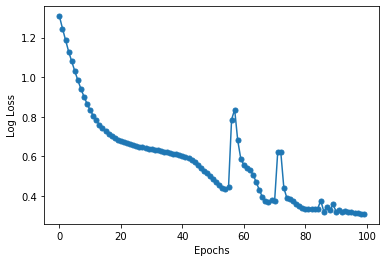

Training accuracy 0.8907
Validation accuracy 0.892
Wall time: 392 ms


In [50]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

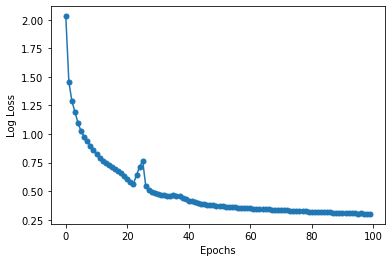

Training accuracy 0.8947
Validation accuracy 0.904
Wall time: 391 ms


In [57]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

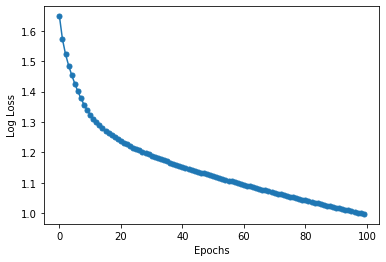

Training accuracy 0.52
Validation accuracy 0.524
Wall time: 372 ms


In [61]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

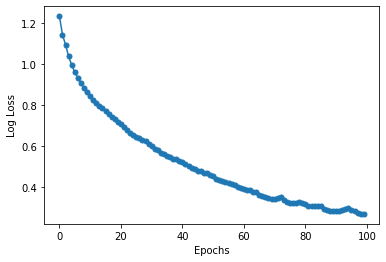

Training accuracy 0.904
Validation accuracy 0.916
Wall time: 361 ms


In [63]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

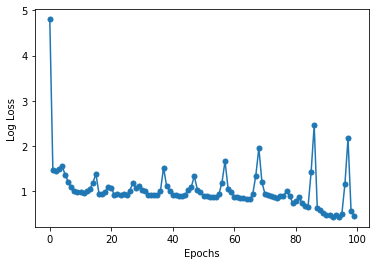

Training accuracy 0.8307
Validation accuracy 0.848
Wall time: 374 ms


In [65]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

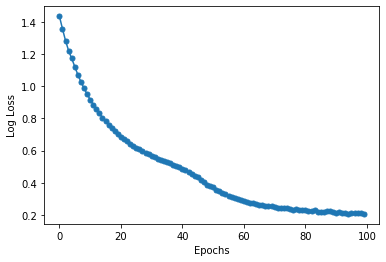

Training accuracy 0.9187
Validation accuracy 0.944
Wall time: 456 ms


In [78]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta1=0.5, beta2=0.5, display_loss=True)
print_accuracy()

## Good configurations with each algo

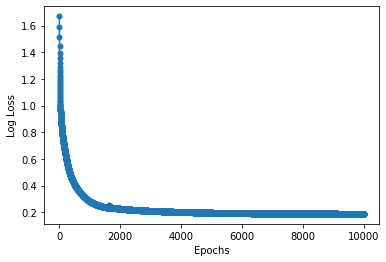

Training accuracy 0.9293
Validation accuracy 0.932
Wall time: 11.9 s


In [81]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
print_accuracy()

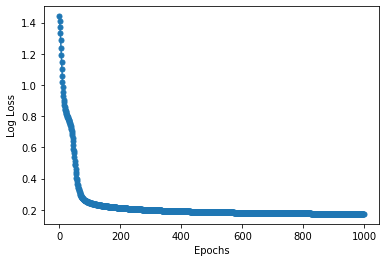

Training accuracy 0.9267
Validation accuracy 0.944
Wall time: 1.54 s


In [83]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

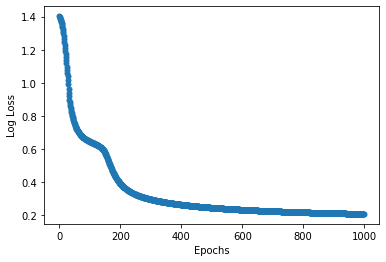

Training accuracy 0.9213
Validation accuracy 0.94
Wall time: 1.54 s


In [85]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

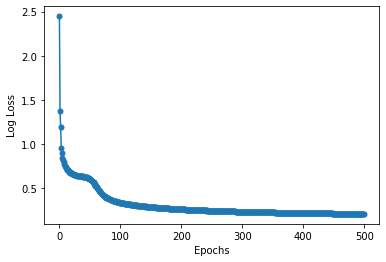

Training accuracy 0.924
Validation accuracy 0.936
Wall time: 950 ms


In [87]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

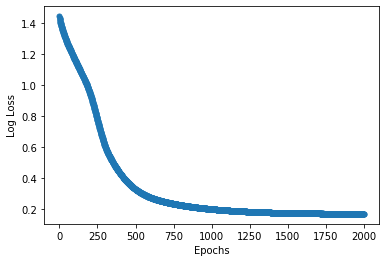

Training accuracy 0.924
Validation accuracy 0.94
Wall time: 2.93 s


In [89]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

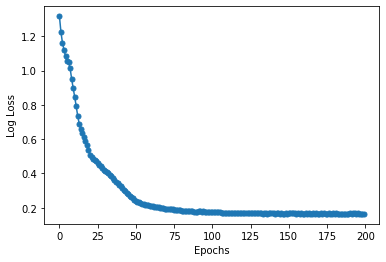

Training accuracy 0.924
Validation accuracy 0.944
Wall time: 727 ms


In [91]:
%%time
model = FFNetwork()
model.fit(X_train, y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()